## Installation of Required Packages
This cell installs `torchinfo`, a utility for model inspection. Ensure packages are installed to avoid errors in the notebook.


In [ ]:
!pip install torchinfo

## Importing Libraries
We import essential libraries for building, training, and visualizing our neural network. This includes PyTorch, torchvision for dataset handling, matplotlib for plotting, and other utilities.


In [4]:
import os
import numpy as np
from collections import Counter
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# PyTorch imports
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchinfo import summary

# Torchvision imports
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0

# Scikit-learn imports
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


## Device Selection
We set up the device for model training and evaluation, utilizing CUDA if available, or defaulting to the CPU.


In [5]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
device

device(type='cuda')

## Preparing the Training Dataset
We load and transform the training dataset using `torchvision.datasets.ImageFolder`. Images are resized to 224x224 and converted to tensors. This setup allows us to standardize image input dimensions across the dataset.


In [ ]:
train_dir = "/Data/train"

image_size = (224, 224)


train_transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.RandomHorizontalFlip(),

          transforms.RandomRotation(10),
        transforms.ToTensor(),

    ]
)


train_data = ImageFolder(train_dir, transform=train_transform)
class_names = train_data.classes
class_to_idx = train_data.class_to_idx

train_data

Dataset ImageFolder
    Number of datapoints: 1156
    Root location: /content/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )

## Preparing the Test Dataset
Like the training dataset, we load and transform the test dataset for model evaluation. The same transformations ensure consistency across training and testing phases.


In [ ]:
test_dir = "/Data/test"
test_transform = transforms.Compose(
    [
        transforms.Resize(image_size),  # Resize to target size
        transforms.ToTensor(),  # Convert image to tensor

    ]
)

test_data = ImageFolder(test_dir, transform=test_transform)

test_data

Dataset ImageFolder
    Number of datapoints: 502
    Root location: /content/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [8]:
print(f"Number of training samples: {len(train_data)}")
print(f"Number of test samples: {len(test_data)}")
print(f"Class names: {class_names}")

Number of training samples: 1156
Number of test samples: 502
Class names: ['Ajwa', 'Galaxy', 'Mejdool', 'Meneifi', 'NabtatAli', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']


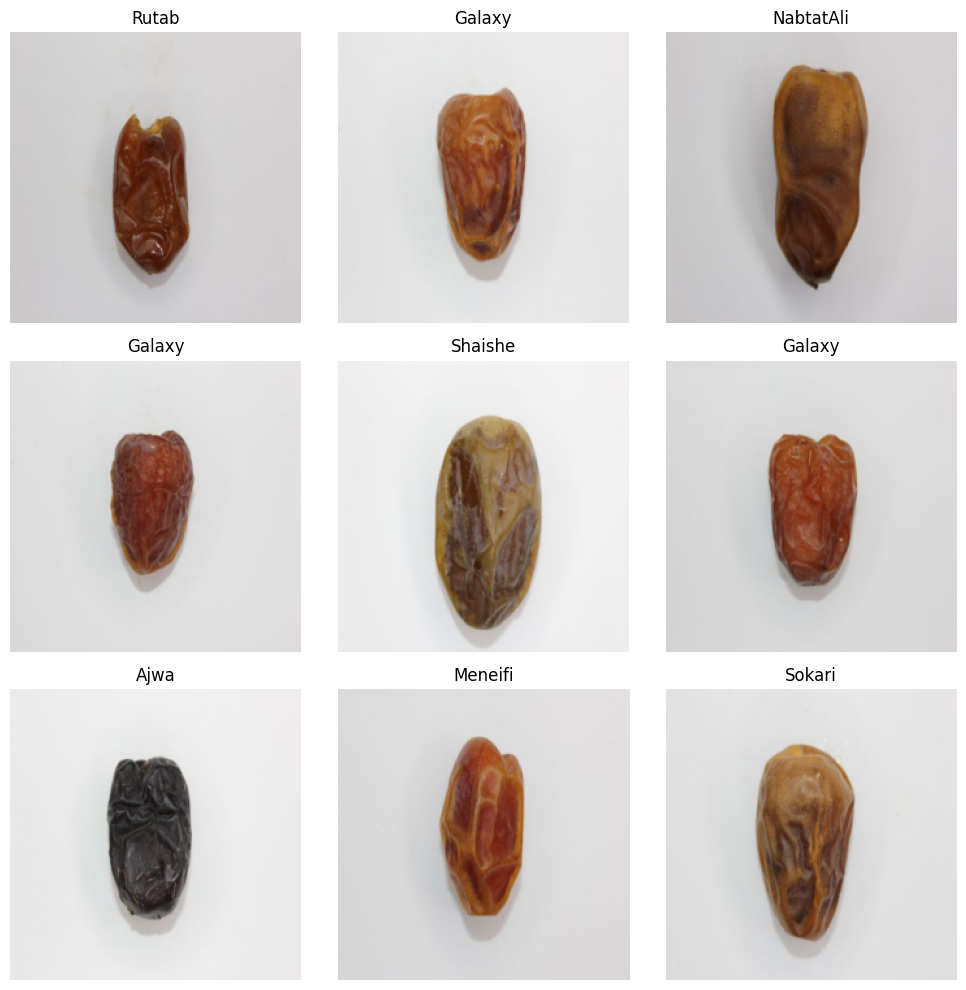

In [9]:
fig = plt.figure(figsize=(10, 10))

row, col = 3, 3

for i in range(9):
    ax = fig.add_subplot(row, col, i + 1)
    random_idx = torch.randint(low=0, high=len(test_data), size=[1]).item()
    img, label = test_data[random_idx]

    ax.imshow(
        img.permute(1, 2, 0),
    )
    ax.set_title(class_names[label])
    ax.axis("off")

plt.tight_layout()
plt.show()

## Visualizing Class Distribution
Here, we visualize the distribution of classes within the training and test datasets. This helps identify any class imbalances, which could affect model performance.


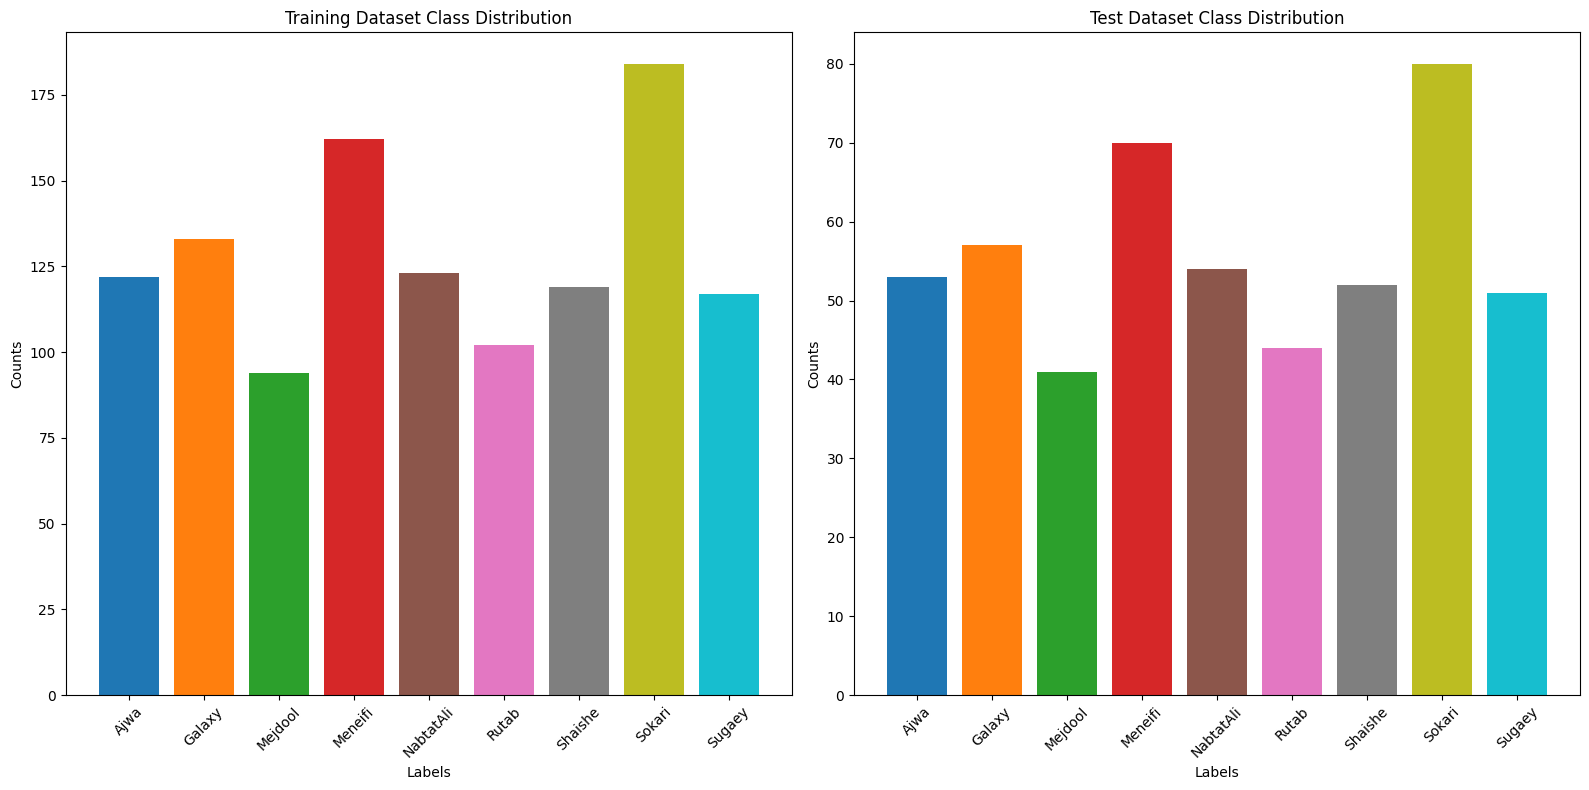

In [10]:
train_count_dir = dict(Counter(train_data.targets))
train_count_dir = {class_names[key]: value for key, value in train_count_dir.items()}

test_count_dir = dict(Counter(test_data.targets))
test_count_dir = {class_names[key]: value for key, value in test_count_dir.items()}

colors = plt.cm.tab10(np.linspace(0, 1, len(train_count_dir)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Training dataset plot
ax1.bar(list(train_count_dir.keys()), list(train_count_dir.values()), color=colors)
ax1.set_xlabel("Labels")
ax1.set_ylabel("Counts")
ax1.set_title("Training Dataset Class Distribution")
ax1.tick_params(axis="x", rotation=45)

# Test dataset plot
ax2.bar(list(test_count_dir.keys()), list(test_count_dir.values()), color=colors)
ax2.set_xlabel("Labels")
ax2.set_ylabel("Counts")
ax2.set_title("Test Dataset Class Distribution")
ax2.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

## DataLoader Setup
We create `DataLoader` instances for the training and test datasets, enabling efficient data batching and parallel loading. A batch size of 64 is chosen, with data shuffling applied only to the training set.


In [11]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 64

generator = torch.Generator(device=device) if device.type == "mps" else None


train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, generator=generator)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, generator=generator)

## Custom CNN Model Definition
The `Date_Custom_CNN` class defines a convolutional neural network tailored for image classification. It consists of:
- **Convolutional Layers**: Two blocks of convolutional, batch normalization, activation, and pooling layers for feature extraction.
- **Classifier**: A fully connected layer for classification, preceded by dropout layers to prevent overfitting.

This model is optimized for recognizing features in date fruit images.


In [ ]:

class Date_Custom_CNN(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super(Date_Custom_CNN, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,kernel_size=3,stride=1,padding=1,),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1,),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),)
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units * 2,kernel_size=3,stride=1,padding=1,),
            nn.BatchNorm2d(hidden_units * 2),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units * 2,out_channels=hidden_units * 2,kernel_size=3,stride=1,padding=1,),
            nn.BatchNorm2d(hidden_units * 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units * 2,out_channels=hidden_units * 4,kernel_size=3,stride=1,padding=1,),
            nn.BatchNorm2d(hidden_units * 4),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units * 4,out_channels=hidden_units * 4,kernel_size=3,stride=1,padding=1,),
            nn.BatchNorm2d(hidden_units * 4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units * 4,out_channels=hidden_units * 4,kernel_size=3,stride=1,padding=1,),
            nn.BatchNorm2d(hidden_units * 4),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units * 4,out_channels=hidden_units * 4,kernel_size=3,stride=1,padding=1,),
            nn.BatchNorm2d(hidden_units * 4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), )

        self.classifier = nn.Sequential(

            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=hidden_units *14*14 *4, out_features=output_shape),
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        # print(x.shape)
        x = self.classifier(x)
        return x


In [ ]:
model = Date_Custom_CNN(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)

model(torch.randn(1, 3, 224, 224).to(device))
summary(model, input_size=(1, 3, 224, 224))


Layer (type:depth-idx)                   Output Shape              Param #
Date_Custom_CNN                          [1, 9]                    --
├─Sequential: 1-1                        [1, 10, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 10, 224, 224]         280
│    └─BatchNorm2d: 2-2                  [1, 10, 224, 224]         20
│    └─ReLU: 2-3                         [1, 10, 224, 224]         --
│    └─Conv2d: 2-4                       [1, 10, 224, 224]         910
│    └─BatchNorm2d: 2-5                  [1, 10, 224, 224]         20
│    └─ReLU: 2-6                         [1, 10, 224, 224]         --
│    └─MaxPool2d: 2-7                    [1, 10, 112, 112]         --
├─Sequential: 1-2                        [1, 20, 56, 56]           --
│    └─Conv2d: 2-8                       [1, 20, 112, 112]         1,820
│    └─BatchNorm2d: 2-9                  [1, 20, 112, 112]         40
│    └─ReLU: 2-10                        [1, 20, 112, 112]         --
│    └─Con

## Model Training Loop
In this section, we define the training loop to optimize our `Date_Custom_CNN` model. For each epoch:
1. **Forward Pass**: We compute the model's output for each batch of training images.
2. **Loss Calculation**: Using the  CrossEntropyLoss, we calculate the difference between predictions and ground-truth labels.
3. **Backpropagation**: We calculate gradients for each parameter to adjust the model weights.
4. **Parameter Update**: The optimizer updates model parameters based on calculated gradients, aiming to minimize the loss over time.

This loop helps the model learn and improve its classification accuracy over epochs.


In [12]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
):

    model.train()

    train_loss, train_acc = 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(y_pred,  dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc


def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device,
):
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            test_preds = model(X)

            loss = loss_fn(test_preds, y)
            test_loss += loss.item()

            test_pred_labels = test_preds.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


def training(
    model: torch.nn.Module,
    train_dataloader,
    test_dataloader,
    optimizer,
    device: torch.device,
    loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
    epochs: int = 5,
    checkpoint_path: str = 'best_model.pth',
    scheduler = None

):

    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    best_acc = 0.0



    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,)
        test_loss, test_acc = test_step(
            model=model, dataloader=test_dataloader, loss_fn=loss_fn, device=device
        )

        current_lr = scheduler.get_last_lr()[0] if scheduler else optimizer.param_groups[0]['lr']
        print(
            f"Epoch: {epoch} | LR: {current_lr:.6f} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), checkpoint_path)

        if scheduler:
            scheduler.step()


    model.load_state_dict(torch.load(checkpoint_path, weights_only=True))

    return results

In [ ]:

EPOCHS = 100

LR = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=LR , momentum=0.9,weight_decay=2e-05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# Ensure the model is on the correct device
model.to(device)

results = training(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=EPOCHS,
    device=device,
    scheduler = scheduler
)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | LR: 0.001000 | Train loss: 1.8009 | Train acc: 0.3668 | Test loss: 2.3692 | Test acc: 0.1055
Epoch: 1 | LR: 0.001000 | Train loss: 1.1432 | Train acc: 0.6077 | Test loss: 2.4395 | Test acc: 0.2070
Epoch: 2 | LR: 0.000999 | Train loss: 0.9457 | Train acc: 0.6933 | Test loss: 7.7531 | Test acc: 0.2985
Epoch: 3 | LR: 0.000998 | Train loss: 0.6983 | Train acc: 0.7689 | Test loss: 3.2442 | Test acc: 0.4757
Epoch: 4 | LR: 0.000996 | Train loss: 0.5775 | Train acc: 0.8026 | Test loss: 0.7131 | Test acc: 0.7514
Epoch: 5 | LR: 0.000994 | Train loss: 0.5179 | Train acc: 0.8322 | Test loss: 2.5737 | Test acc: 0.4970
Epoch: 6 | LR: 0.000991 | Train loss: 0.4433 | Train acc: 0.8470 | Test loss: 0.7023 | Test acc: 0.7801
Epoch: 7 | LR: 0.000988 | Train loss: 0.3678 | Train acc: 0.8799 | Test loss: 0.6569 | Test acc: 0.8046
Epoch: 8 | LR: 0.000984 | Train loss: 0.3972 | Train acc: 0.8717 | Test loss: 0.4770 | Test acc: 0.8309
Epoch: 9 | LR: 0.000980 | Train loss: 0.2914 | Train acc: 0.9054

<ipython-input-13-3e96d74929a9>:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


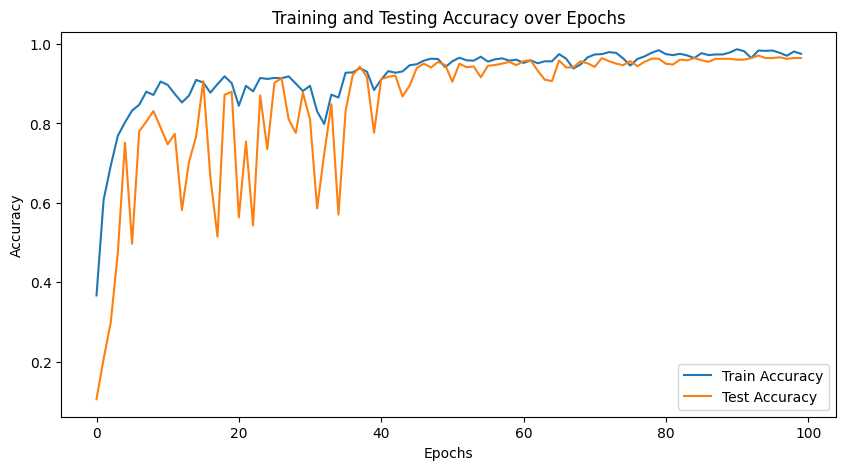

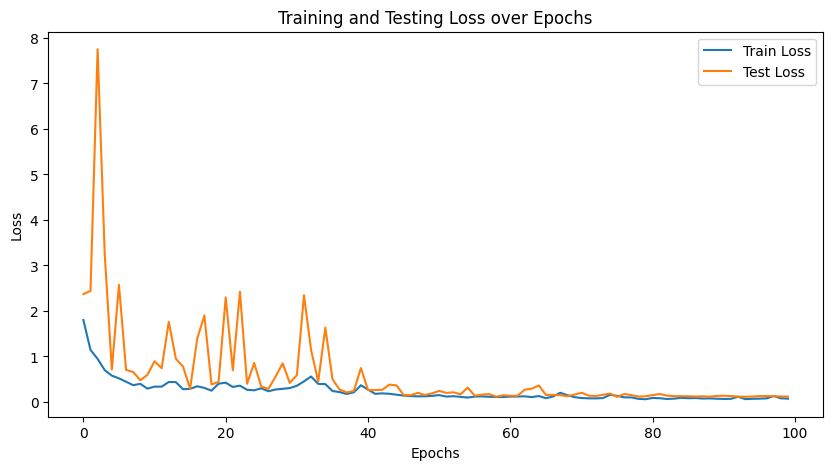

In [ ]:

# Plot for accuracy
plt.figure(figsize=(10, 5))
plt.plot(results["train_acc"], label='Train Accuracy')
plt.plot(results["test_acc"], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy over Epochs')
plt.legend()
plt.show()

# Plot for loss
plt.figure(figsize=(10, 5))
plt.plot(results["train_loss"], label='Train Loss')
plt.plot(results["test_loss"], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.show()

## Model Evaluation on Test Data
After training, we evaluate the model on the test dataset to assess its generalization. Here:
1. **Accuracy Calculation**: We compute the accuracy on test data, providing a simple measure of model performance.
2. **Confusion Matrix**: We visualize a confusion matrix, showing the counts of correct and incorrect predictions per class.

This matrix helps identify which classes the model struggles with and provides insights for potential improvements.


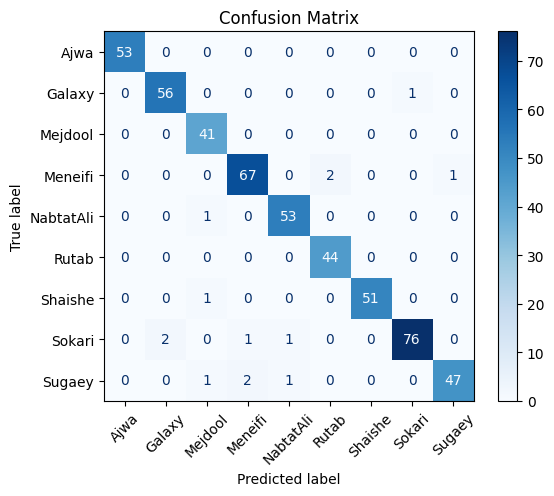

In [ ]:
model.eval()

# Initialize lists to store true labels and predictions
all_preds = []
all_labels = []

# Disable gradient calculation for efficiency
with torch.inference_mode():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Get model predictions
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Append predictions and labels to the lists
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()


In [ ]:
print(classification_report(all_labels, all_preds, target_names=class_names))

              precision    recall  f1-score   support

        Ajwa       1.00      1.00      1.00        53
      Galaxy       0.97      0.98      0.97        57
     Mejdool       0.93      1.00      0.96        41
     Meneifi       0.96      0.96      0.96        70
   NabtatAli       0.96      0.98      0.97        54
       Rutab       0.96      1.00      0.98        44
     Shaishe       1.00      0.98      0.99        52
      Sokari       0.99      0.95      0.97        80
      Sugaey       0.98      0.92      0.95        51

    accuracy                           0.97       502
   macro avg       0.97      0.97      0.97       502
weighted avg       0.97      0.97      0.97       502



# Comparison with EfficientNet-B0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0 | LR: 0.001000 | Train loss: 0.8340 | Train acc: 0.7615 | Test loss: 1.1028 | Test acc: 0.6913
Epoch: 1 | LR: 0.000997 | Train loss: 0.3292 | Train acc: 0.9112 | Test loss: 0.5918 | Test acc: 0.7953
Epoch: 2 | LR: 0.000989 | Train loss: 0.2412 | Train acc: 0.9202 | Test loss: 0.1988 | Test acc: 0.9376
Epoch: 3 | LR: 0.000976 | Train loss: 0.1065 | Train acc: 0.9646 | Test loss: 0.0682 | Test acc: 0.9817
Epoch: 4 | LR: 0.000957 | Train loss: 0.1008 | Train acc: 0.9679 | Test loss: 0.1733 | Test acc: 0.9450
Epoch: 5 | LR: 0.000933 | Train loss: 0.0834 | Train acc: 0.9778 | Test loss: 0.0828 | Test acc: 0.9785
Epoch: 6 | LR: 0.000905 | Train loss: 0.0772 | Train acc: 0.9671 | Test loss: 0.0367 | Test acc: 0.9899
Epoch: 7 | LR: 0.000872 | Train loss: 0.1011 | Train acc: 0.9564 | Test loss: 0.0842 | Test acc: 0.9668
Epoch: 8 | LR: 0.000835 | Train loss: 0.1134 | Train acc: 0.9688 | Test loss: 0.0483 | Test acc: 0.9833
Epoch: 9 | LR: 0.000794 | Train loss: 0.1408 | Train acc: 0.9465

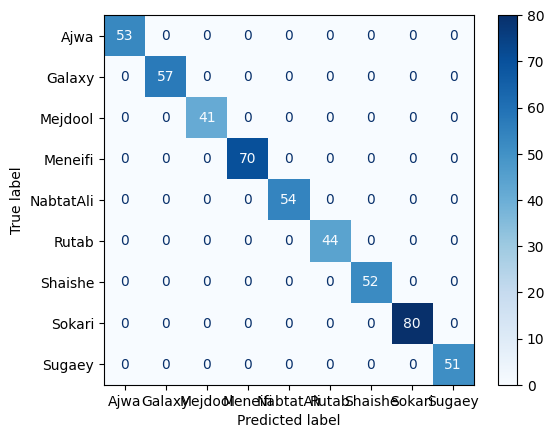

In [20]:
pretrained_model = efficientnet_b0(pretrained=True)

pretrained_model.classifier[1] = nn.Linear(pretrained_model.classifier[1].in_features, 9)

pretrained_model.to(device)
EPOCHS = 30

LR = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=pretrained_model.parameters(), lr=LR )
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

results_pretrained = training(
    model=pretrained_model,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=EPOCHS,
    device=device,
    scheduler = scheduler
)

pretrained_model.eval()
all_preds_pretrained = []
all_labels_pretrained = []

with torch.inference_mode():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = pretrained_model(images)
        _, preds = torch.max(outputs, 1)
        all_preds_pretrained.extend(preds.cpu().numpy())
        all_labels_pretrained.extend(labels.cpu().numpy())

# Classification report and confusion matrix
print("EfficientNet-B0:")
print(classification_report(all_labels_pretrained, all_preds_pretrained, target_names=class_names))
cm_efficientnet = confusion_matrix(all_labels_pretrained, all_labels_pretrained)
ConfusionMatrixDisplay(confusion_matrix=cm_efficientnet, display_labels=class_names).plot(cmap="Blues")
plt.show()


### Model Size vs Accuracy Comparison

#### Custom Model
- **Model Parameters**: 128,199
- **Model Size**: ~30.22 MB
- **Accuracy**: 97%

#### EfficientNet-B0
- **Model Parameters**: Original 5,288,548 after modifying the FC 4,019,077
- **Model Size**: ~124.56 MB
- **Accuracy**: 100%



#### Summary Table

| Model           | Parameters | Size (MB) | Accuracy (%) |
|------------------|------------|-----------|--------------|
| Custom Model     | 128,199    | 30.22     | 97           |
| EfficientNet-B0  | 4,019,077   | ~20       | 100          |

### Model Size Comparison
- **Custom Model Size**: 30.22 MB
- **EfficientNet-B0 Size**: 124.56 MB
- **Calculation**: `124.56 / 30.22 ≈ 4.12`
- **EfficientNet-B0** is approximately **4.12 times bigger** than the Custom Model in terms of model size.

### Parameter Count Comparison
- **Custom Model Parameters**: 128,199
- **EfficientNet-B0 Parameters**: 4,019,077
- **Calculation**: `4,019,077 / 128,199 ≈ 31.36`
- **EfficientNet-B0** has approximately **31.36 times more parameters** than the Custom Model.

